# Analysis of Results

The goal of this notebook is to validate the results of the pipeline, ie, understanding:
- If we were able to detect clusters of similar sites
- Understand the size and properties of such clusters
- Validate TP/FP and understand how to improve

## 1. Setup

In [128]:
# importing relevant libraries
import pandas as pd
pd.set_option('display.max_rows', 500)

from sklearn.manifold import TSNE
import altair as alt
import time
from html2image import Html2Image
from bs4 import BeautifulSoup
from google.cloud import storage
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# setting plot style
import altair_theme
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [129]:
# import data
processed_data = pd.read_csv("../data/processed/processed_data.csv")
scored_data = pd.read_csv("../data/scored/similar_groups.csv")[["domain", "cluster_id"]]

# sites that did not pass to the dbscan phase are marked as -2
# sites that passed the dbscan phase, but were not associated with any cluster are marked as -1 by definition
scored_data = processed_data.merge(scored_data, on='domain', how='left').fillna(-2)

## 2. Structure and Counts of Clusters Found

In [139]:
scored_data["unique_combo"] = scored_data["div"].astype(str) + scored_data["a"].astype(str) + \
    scored_data["img"].astype(str) + scored_data["span"].astype(str) + scored_data["li"].astype(str)

agg = scored_data[scored_data["cluster_id"]>=0]\
    .groupby(['cluster_id'], as_index=False)\
    .agg(number_domains=pd.NamedAgg(column="cluster_id", aggfunc="count"),
         unique_combos=pd.NamedAgg(column="unique_combo", aggfunc=pd.Series.nunique))

In [141]:
# number of clusters found
len(agg)

9

In [142]:
agg.sort_values("number_domains", ascending=False)

,cluster_id,number_domains,unique_combos
4,4.0,13,1
2,2.0,12,2
1,1.0,10,4
8,8.0,10,3
0,0.0,7,1
5,5.0,6,3
3,3.0,5,1
6,6.0,4,3
7,7.0,4,4


## 3. FP / TP Analysis

In [134]:
def get_storage_bucket():
    storage_client = storage.Client()
    bucket = storage_client.bucket("site_html_data_ops")
    return bucket

def get_html(domain):
    try:
        bucket=get_storage_bucket()
        html = bucket.blob(domain + ".html").download_as_string()
    except:
        return Null
    return html

def get_screenshot(domain):
    hti = Html2Image(output_path='screenshots')
    hti.screenshot(url="https://" + domain, save_as='%s.png'%domain)

In [146]:
def get_cluster_info(target_cluster, n):

    cluster_data = scored_data[scored_data["cluster_id"]==target_cluster].copy()
    img_list = []
    html_list = []
    for domain in cluster_data["domain"][0:n]:
        if domain + ".pgn" not in os.listdir("screenshots/"):
            get_screenshot(domain)
        img_list.append(mpimg.imread("screenshots/" + domain + ".png"))
        html_list.append(get_html(domain))
    return img_list, html_list

In [147]:
def plot_sample(target_cluster, n):
    img_list = get_cluster_info(target_cluster, n)[0]
    
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=(2, 3), 
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, img_list):
        ax.imshow(im)

    plt.show()


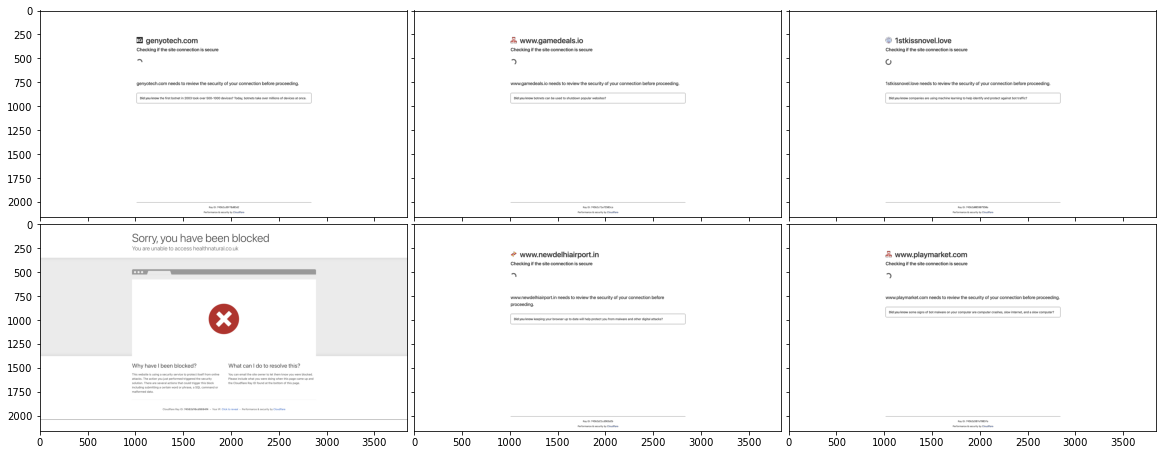

In [148]:
# cluster 0
plot_sample(0, 6)

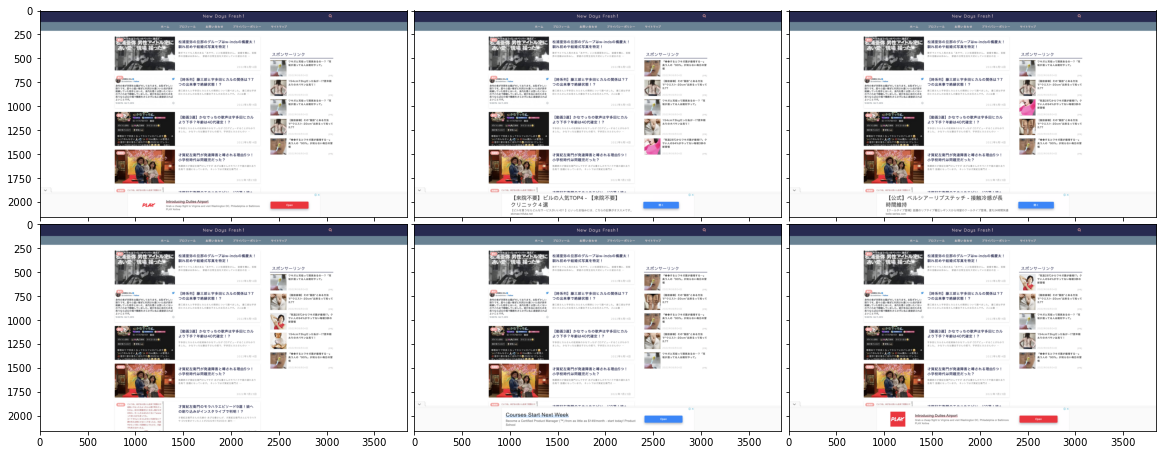

In [150]:
# cluster 1
plot_sample(1, 6)

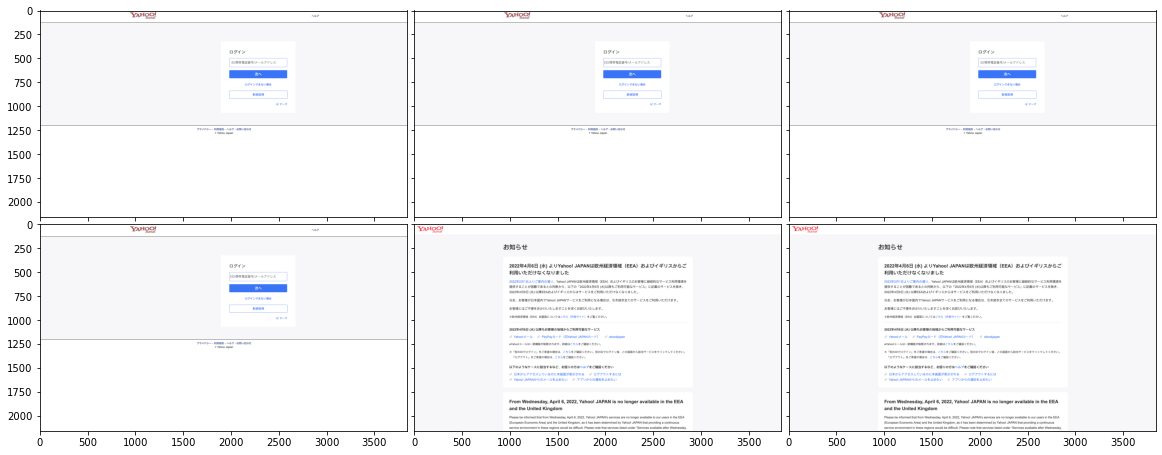

In [151]:
# cluster 2
plot_sample(2, 6)

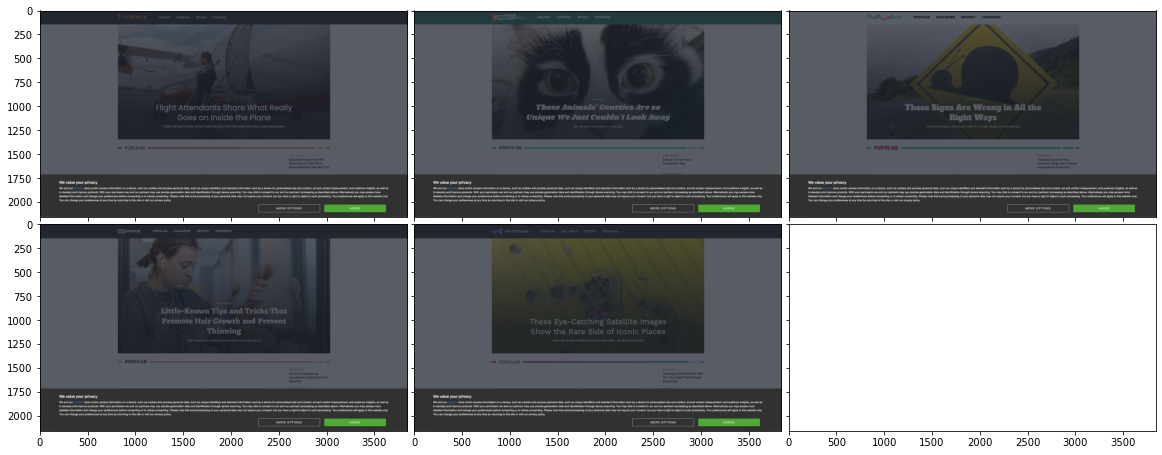

In [152]:
# cluster 3
plot_sample(3, 6)

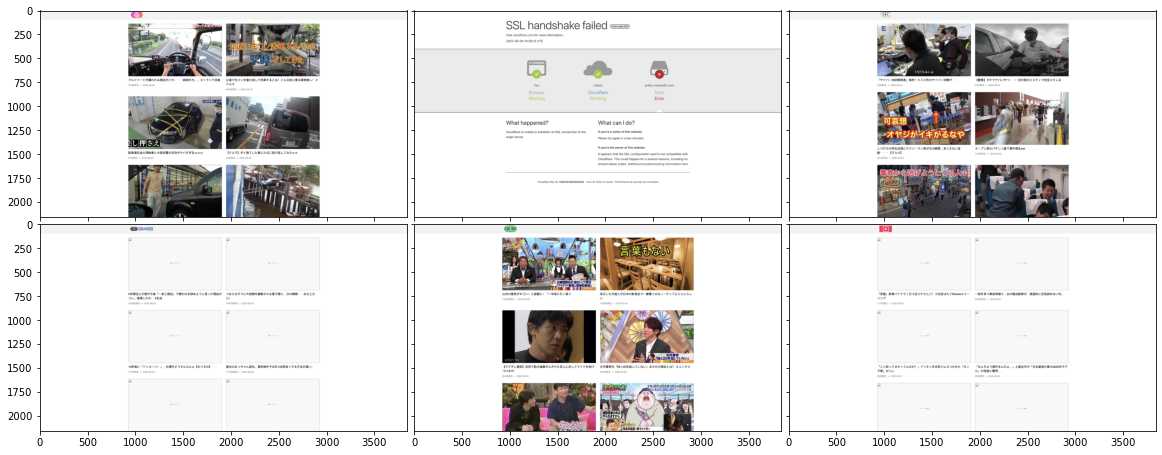

In [153]:
# cluster 4
plot_sample(4, 6)

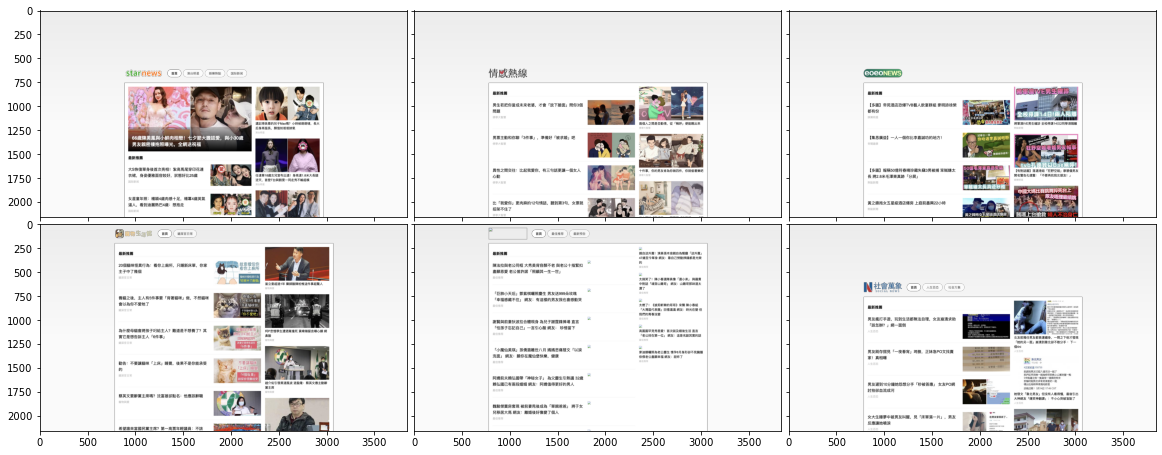

In [154]:
# cluster 5
plot_sample(5, 6)

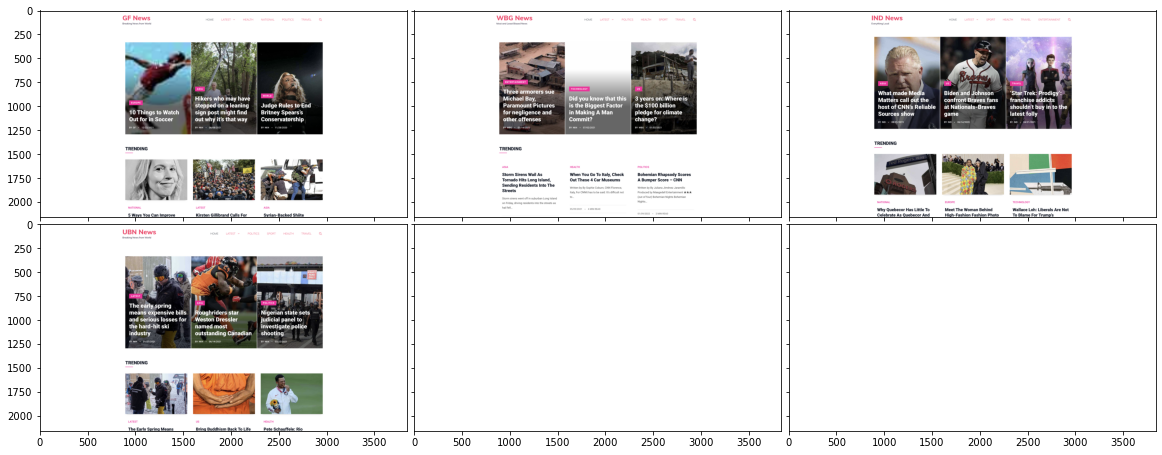

In [155]:
# cluster 6
plot_sample(6, 6)

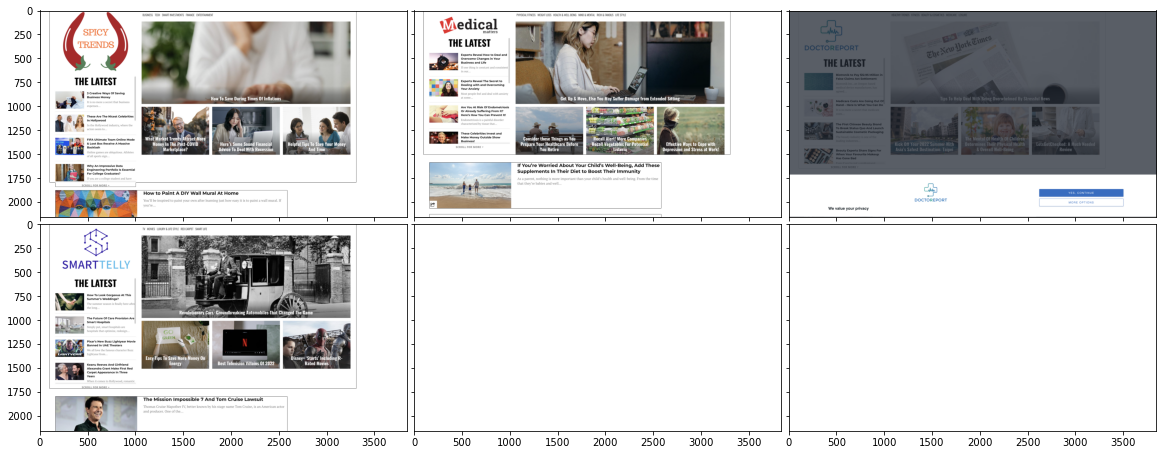

In [156]:
# cluster 7
plot_sample(7, 6)

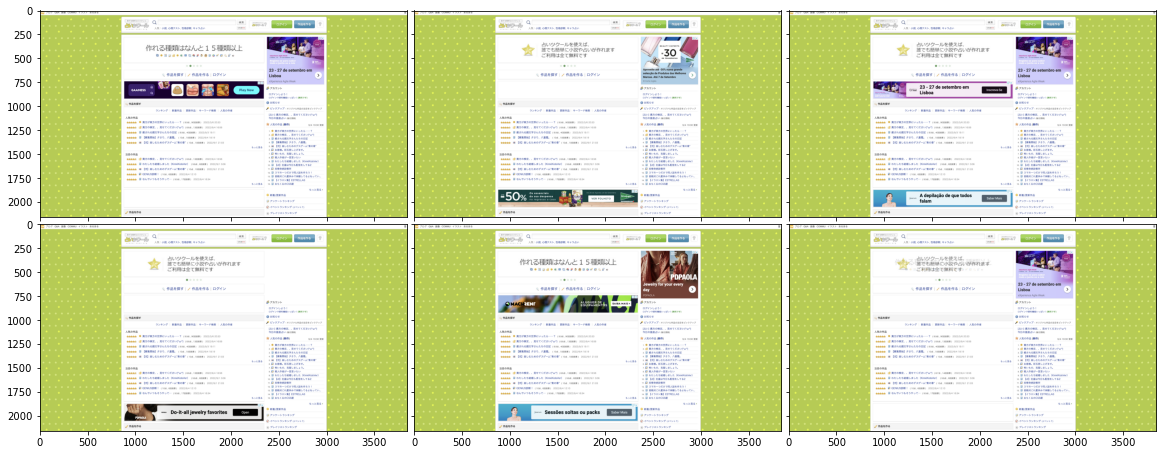

In [157]:
# cluster 8
plot_sample(8, 6)